In [67]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
import json
import mrcfile
import umap

from cryo_sbi.inference.models import build_models
from cryo_sbi.inference import priors
from cryo_sbi.utils.estimator_utils import sample_posterior, compute_latent_repr
from cryo_sbi.utils.image_utils import (
    LowPassFilter,
    NormalizeIndividual,
    MRCtoTensor,
    FourierDownSample,
    Mask,
    AddLowFrequencyNoise,
)

import zuko

import torch
import torchvision.models as models
import torch.nn as nn
import numpy as np
import json
from scipy.spatial.transform import Rotation

from cryo_sbi.wpa_simulator.ctf import calc_ctf, apply_ctf
from cryo_sbi.wpa_simulator.image_generation import gen_img, gen_quat
from cryo_sbi.wpa_simulator.noise import add_noise
from cryo_sbi.wpa_simulator.normalization import gaussian_normalize_image
from cryo_sbi.wpa_simulator.padding import pad_image
from cryo_sbi.wpa_simulator.shift import apply_no_shift, apply_random_shift
from cryo_sbi.wpa_simulator.validate_image_config import check_params

In [68]:
def gen_noise_field(num_pixels, parameters, num_sin_func=50, max_intensity=1):
    x = torch.linspace(-100, 100, num_pixels)
    y = torch.linspace(-100, 100, num_pixels)
    xx, yy = torch.meshgrid(x, y, indexing="ij")

    noise_field = torch.zeros_like(xx, dtype=torch.double)
    for i in range(num_sin_func):
        noise_field += (
            parameters[i, 0]
            * torch.sin(parameters[i, 1] * xx + parameters[i, 2])
            * torch.sin(parameters[i, 3] * yy + parameters[i, 4])
        )
    noise_field = max_intensity * (noise_field / noise_field.max())
    return noise_field


def add_noise_field(image, parameters):
    """Add a noise field to an image.

    Args:
        image (torch.Tensor): Image of shape (n_pixels, n_pixels) or (n_channels, n_pixels, n_pixels).
        min_intensity (float): Minimum intensity of the image.

    Returns:
        torch.Tensor: Image with noise field.
    """

    noise_field = gen_noise_field(
        image.shape[0], parameters, num_sin_func=200, max_intensity=1
    )
    # idx_replace = image < min_image_intensity
    # image[idx_replace] = noise_field[idx_replace]
    image += noise_field * image.max() * parameters[0, 5]

    return image

In [69]:
class CryoEmSimulator:
    """Simulator for cryo-EM images.

    Args:
        config_fname (str): Path to the configuration file.

    Attributes:
        config (dict): Configuration parameters.
        models (np.ndarray): The models to use for image generation.
        rot_mode (str): The rotation mode to use. Can be "random", "list" or None.
        quaternions (np.ndarray): The quaternions to use for image generation.
        add_noise (bool): function which adds noise to images. Defaults to Gaussian noise.
    """

    def __init__(self, config_fname):
        self._load_params(config_fname)
        self._load_models()
        self.rot_mode = None
        self.quaternions = None
        self._config_rotations()
        self._pad_width = int(np.ceil(self.config["N_PIXELS"] * 0.1)) + 1
        self.add_noise = add_noise

    def _load_params(self, config_fname):
        config = json.load(open(config_fname))
        check_params(config)
        self.config = config

    def _load_models(self):
        if "hsp90" in self.config["MODEL_FILE"]:
            self.models = np.load(self.config["MODEL_FILE"])[:, 0]

        elif "6wxb" in self.config["MODEL_FILE"]:
            self.models = np.load(self.config["MODEL_FILE"])

        elif "square" in self.config["MODEL_FILE"]:
            self.models = np.transpose(
                np.load(self.config["MODEL_FILE"]).diagonal(), [2, 0, 1]
            )
        print(self.config["MODEL_FILE"])

    def _config_rotations(self):
        if isinstance(self.config["ROTATIONS"], bool):
            if self.config["ROTATIONS"]:
                self.rot_mode = "random"

        elif isinstance(self.config["ROTATIONS"], str):
            self.rot_mode = "list"
            self.quaternions = np.loadtxt(self.config["ROTATIONS"], skiprows=1)

            assert (
                self.quaternions.shape[1] == 4
            ), "Quaternion shape is not 4. Corrupted file?"

    @property
    def max_index(self):
        return len(self.models) - 1

    def _simulator_with_quat(self, index, quaternion, seed):
        index = int(torch.round(index))

        coord = np.copy(self.models[index])

        if quaternion is not None:
            rot_mat = Rotation.from_quat(quaternion).as_matrix()
            coord = np.matmul(rot_mat, coord)

        image = gen_img(coord, self.config)
        image = pad_image(image, self.config)
        image = add_noise_field(image, flow().sample((200,)))

        if self.config["CTF"]:
            image = apply_ctf(image, calc_ctf(self.config))

        if self.config["NOISE"]:
            image = self.add_noise(image, self.config, seed)

        if self.config["SHIFT"]:
            image = apply_random_shift(image, self.config, seed)
        else:
            image = apply_no_shift(image, self.config)

        image = gaussian_normalize_image(image)

        return image.to(dtype=torch.float)

    def simulator(self, index, seed=None):
        if self.rot_mode == "random":
            quat = gen_quat()
        elif self.rot_mode == "list":
            quat = self.quaternions[np.random.randint(0, self.quaternions.shape[0])]
        else:
            quat = None

        image = self._simulator_with_quat(index, quat, seed=seed)

        return image

In [70]:
cryosbi = CryoEmSimulator("../experiments/6wxb/image_params_mixed_training.json")
cryosbi.config["SNR"] = 0.18

../data/protein_models/6wxb_mixed_models.npy


In [71]:
flow = zuko.flows.NSF(6, context=0, transforms=3)

In [72]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.resnet = models.resnet18()
        self.resnet.conv1 = nn.Conv2d(
            1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        self.resnet.fc = nn.Linear(in_features=512, out_features=1, bias=True)
        self._fft_filter = LowPassFilter(128, 15)
        self.sig = torch.nn.Sigmoid()

    def forward(self, x):
        x = self._fft_filter(x)
        x = x.unsqueeze(1)
        x = self.resnet(x)
        x = self.sig(x)
        return x

In [73]:
dis = Discriminator()

In [74]:
final_size = 128
transform = transforms.Compose(
    [
        MRCtoTensor(),
        FourierDownSample(256, final_size),
        # transforms.Resize(size=(128, 128)),
        NormalizeIndividual(),
        # Mask(final_size, 64),
        # LowPassFilter(final_size, 80),
        # NormalizeIndividual(),
    ]
)

In [75]:
particles_transfomed = []
for i in range(1, 30):
    if i < 10:
        img_file = f"../../6wxb/particles/particles_0{i}.mrc"
    else:
        img_file = f"../../6wxb/particles/particles_{i}.mrc"
    tmp_images = transform(img_file)
    particles_transfomed.append(tmp_images)
particles_transfomed = torch.cat(particles_transfomed, dim=0)

In [76]:
optim_dis = torch.optim.Adam(dis.parameters(), lr=0.001)
optim_gen = torch.optim.Adam(flow.parameters(), lr=0.001)
criterion = nn.BCELoss()

0.40351635217666626 0.551034152507782


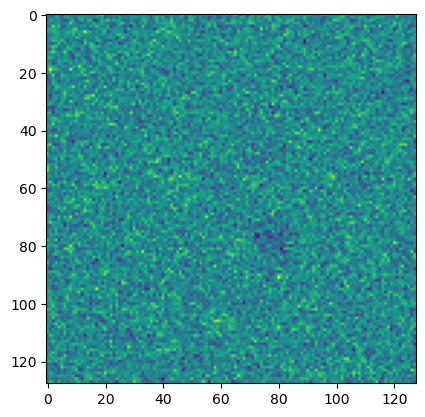

0.1174522265791893 0.8562239408493042


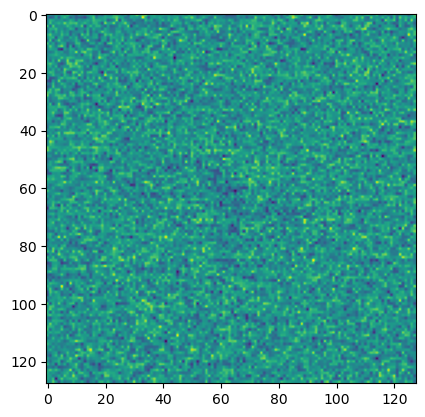

0.05548135191202164 0.9773491024971008


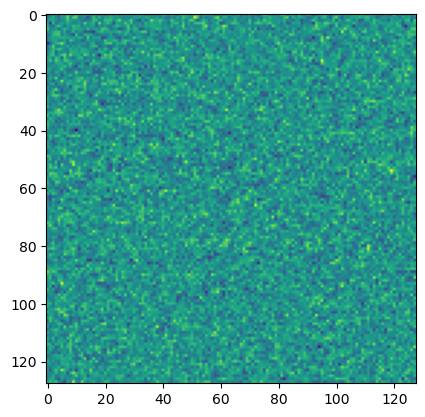

0.04907882586121559 0.9907201528549194


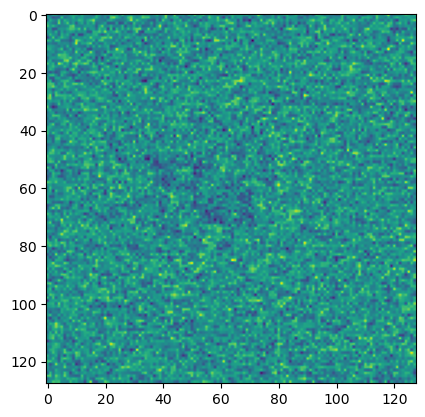

0.008229635655879974 0.995266318321228


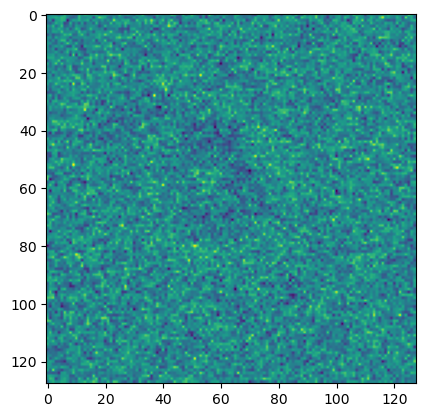

0.2214934378862381 0.9778658747673035


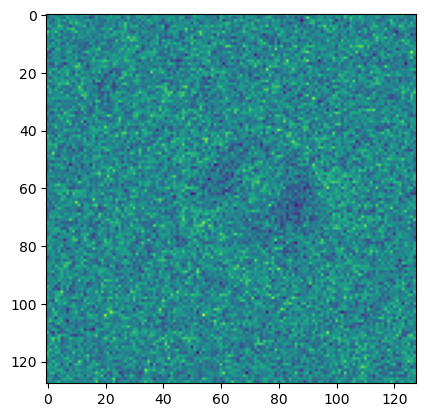

0.06179628521203995 0.8938005566596985


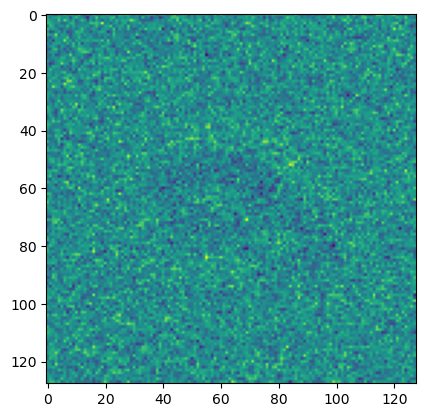

0.057958971709012985 0.9830383062362671


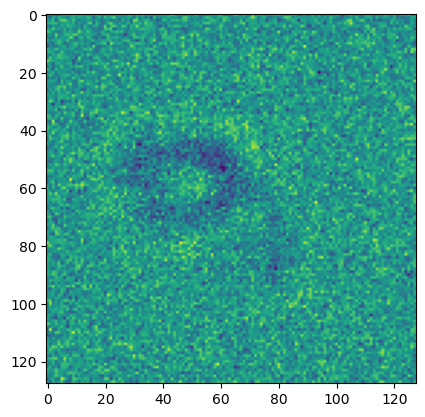

0.016744278371334076 0.9679003953933716


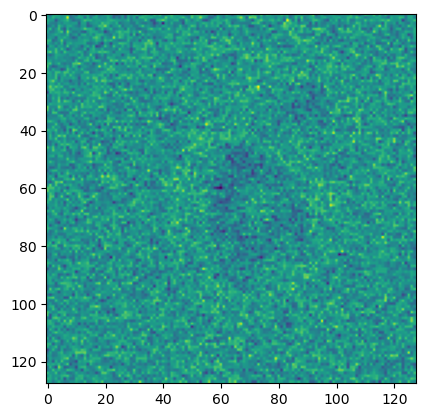

0.011573052033782005 0.991534411907196


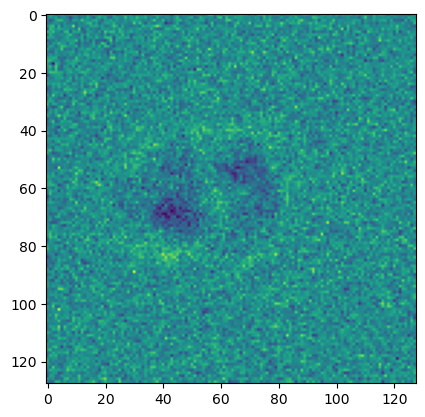

0.00963588710874319 0.9950289726257324


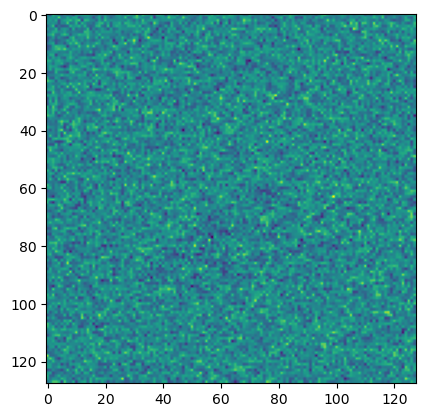

0.013700416311621666 0.9921390414237976


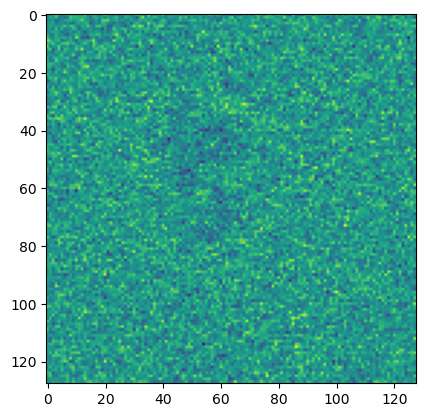

0.0046310522593557835 0.9958696365356445


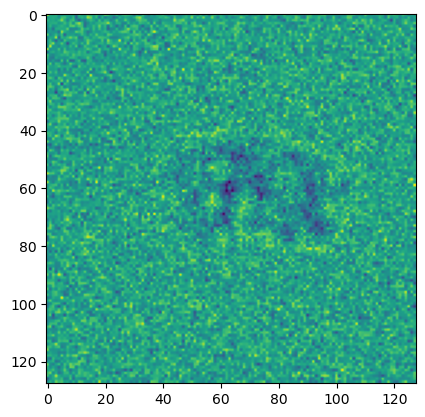

0.004888313356786966 0.9967880249023438


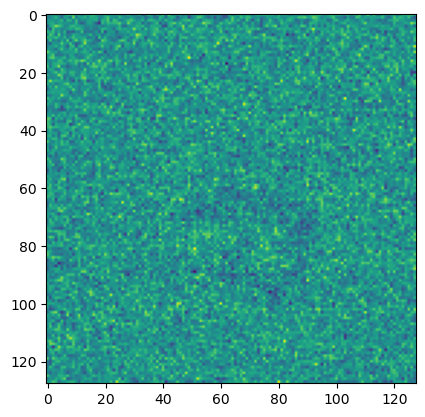

0.0032239302527159452 0.9968459010124207


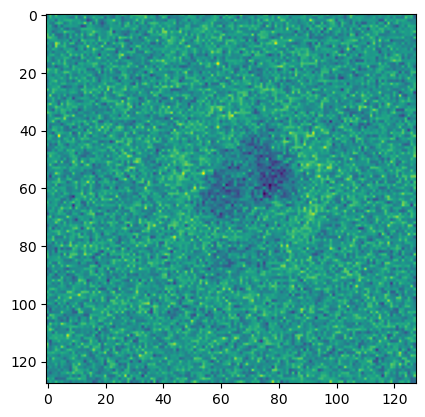

0.0027824179269373417 0.9973205327987671


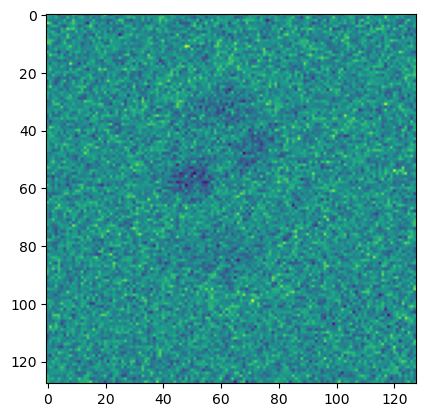

0.0027832253836095333 0.9979903101921082


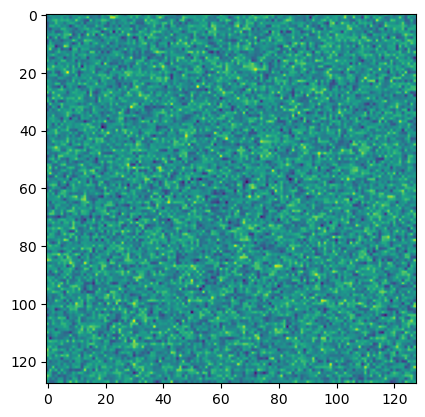

0.002705404069274664 0.9978246688842773


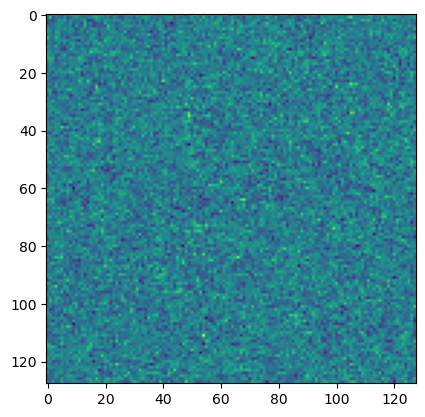

0.0037268325686454773 0.9973794221878052


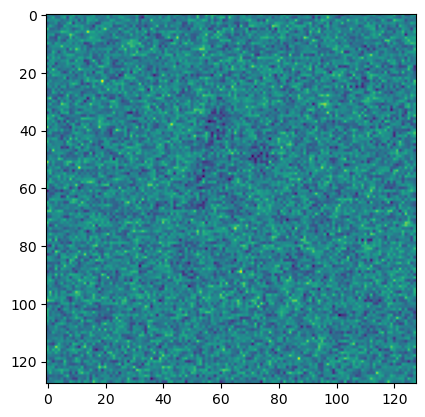

0.003408446442335844 0.9986090660095215


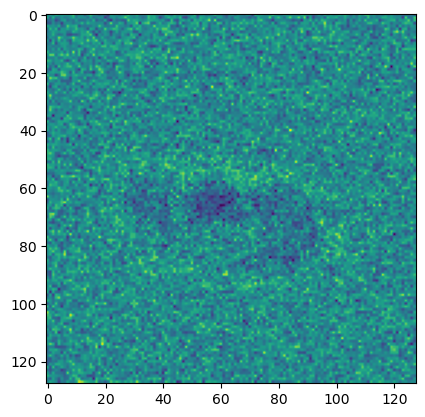

0.002073530573397875 0.9984668493270874


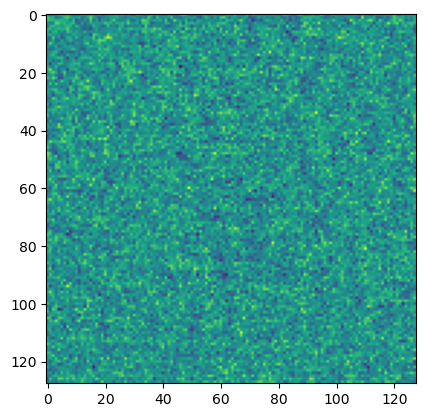

0.0017544396687299013 0.9986764192581177


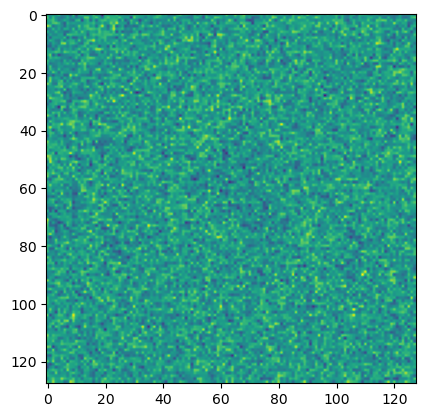

0.001497262273915112 0.9988346099853516


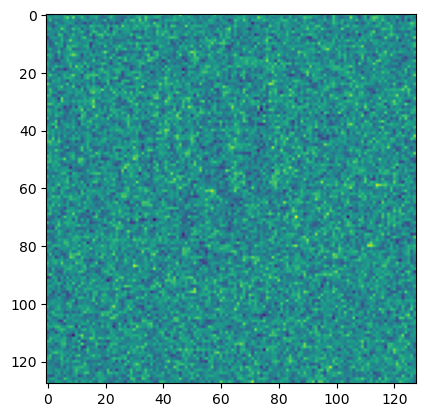

KeyboardInterrupt: 

In [77]:
masking = Mask(128, 32, inside=True)
for i in range(1000):
    for i in range(10):
        indices = torch.tensor(
            np.arange(0, 100, 5, dtype=float)
        )  # 50 * torch.ones((40,), dtype=torch.float)#
        images_sim = torch.stack([cryosbi.simulator(index) for index in indices], dim=0)
        images_real = particles_transfomed[
            torch.randperm(particles_transfomed.shape[0])[:20]
        ]

        # images_real = masking(images_real)
        # images_sim = masking(images_sim)

        # Discriminator step
        optim_dis.zero_grad()
        pred_real = dis(images_real)
        pred_sim = dis(images_sim)

        labels_real = torch.ones_like(pred_real)
        labels_sim = torch.zeros_like(pred_sim)

        loss_real = criterion(pred_real, labels_real)
        loss_sim = criterion(pred_sim, labels_sim)

        loss_real.backward()
        loss_sim.backward()
        optim_dis.step()

        # Generator step
        optim_gen.zero_grad()
        indices = torch.tensor(
            np.arange(0, 100, 5, dtype=float)
        )  # 50 * torch.ones((40,), dtype=torch.float)#
        images_sim = torch.stack([cryosbi.simulator(index) for index in indices], dim=0)
        # images_sim = masking(images_sim)
        pred_sim = dis(images_sim)
        labels_sim = torch.ones_like(pred_sim)
        loss_sim = criterion(pred_sim, labels_sim)

        loss_sim.backward()
        optim_gen.step()
    # print(loss_sim.item(), loss_real.item())
    print(pred_sim.mean().item(), pred_real.mean().item())
    plt.imshow(images_sim[0].squeeze().detach().numpy())
    # plt.imshow(images_real[0].squeeze().detach().numpy())
    plt.show()

In [ ]:
plt.imshow(images_sim[0].squeeze().detach().numpy())

In [ ]:
plt.imshow(images_real[0].squeeze().detach().numpy())

(array([  1.,   0.,   0.,   0.,   1.,   1.,   1.,   1.,   3.,   2.,   2.,
          2.,   2.,   4.,   8.,   5.,  15.,  11.,  21.,  18.,  20.,  36.,
         28.,  40.,  64.,  45.,  75.,  95.,  87., 105., 120., 150., 196.,
        224., 244., 273., 292., 337., 359., 450., 510., 534., 523., 585.,
        597., 584., 609., 639., 636., 671., 666., 659., 567., 609., 614.,
        633., 655., 615., 634., 550., 515., 480., 470., 377., 324., 317.,
        255., 216., 199., 201., 144., 108., 113., 131.,  99.,  72.,  79.,
         60.,  53.,  53.,  37.,  43.,  45.,  33.,  21.,  18.,  20.,  20.,
         16.,   4.,  13.,   6.,  10.,   4.,   5.,   5.,   2.,   2.,   1.,
          1.]),
 array([-4.594011  , -4.5157914 , -4.4375725 , -4.359353  , -4.2811337 ,
        -4.2029147 , -4.1246953 , -4.046476  , -3.968257  , -3.8900375 ,
        -3.8118184 , -3.7335992 , -3.6553798 , -3.5771606 , -3.4989414 ,
        -3.420722  , -3.3425028 , -3.2642837 , -3.1860645 , -3.107845  ,
        -3.029626  , -2.95

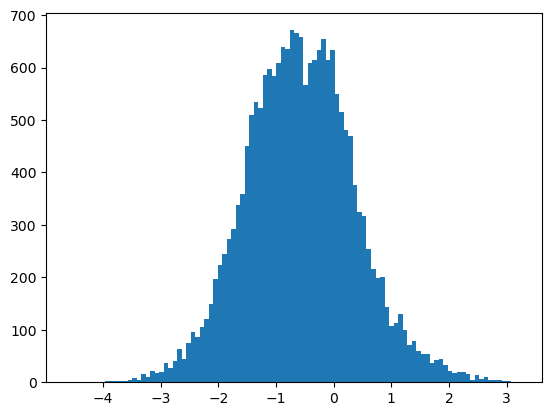

In [84]:
plt.hist(flow().sample((20000,))[:, 1].flatten().numpy(), bins=100)